In [3]:
import tensorflow as tf
from tensorflow import keras 
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np
import os
import gym
import pyvirtualdisplay
from IPython.display import HTML

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([-0.02935158, -0.03580526, -0.03542371, -0.00228992])

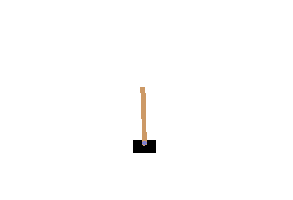

In [3]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    env.close()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [5]:
env.action_space

Discrete(2)

In [6]:
action=1

In [7]:
obs, reward, done, info = env.step(action)
obs

array([-0.03006769,  0.15980634, -0.03546951, -0.30593563])

In [8]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(100):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [9]:
sum(totals)/len(totals)

40.9

### Animating the stick fall

In [10]:
frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode='rgb_array')
    frames.append(img)
    action = basic_policy(obs)
    
    obs,reward,done,info = env.step(action)
    if done:
        env.close()
        break

In [11]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval,
    )
    plt.close()
    return anim

In [12]:
HTML(plot_animation(frames).to_html5_video())

## GradientTape examples

In [13]:
x = tf.constant(3.0)
z = tf.constant(1.0)
with tf.GradientTape() as g:
    g.watch(x)
    y = x*x + 3*z
    dy_dx = g.gradient(y,x)
    tf.print(dy_dx)

6


## Neural Network Policies

In [14]:
n_inputs = 4
model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [15]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_proba = model.predict(obs.reshape(1,-1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, infp = env.step(action)
        if done:
            break
    env.close()
    return frames

In [16]:
frames = render_policy_net(model)
anim = plot_animation(frames)

## Training the NN model to basic policy

In [17]:
n_enviroments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_enviroments)]
for index, env in enumerate(envs):
    env.seed(index)
#np.random.seed(42)
observations = [env.reset() for env in envs]    
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    target_probas = np.array([ ([1.] if obs[2] < 0 else [0.]) 
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print(f"\r Iteration: {iteration}, Loss: {loss.numpy():.3f}", end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_enviroments,1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()
        
for env in envs:
    env.close()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 Iteration: 4999, Loss: 0.048

In [18]:
frames = render_policy_net(model)
plot_animation(frames)

## Policy Gradients

In [19]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [20]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [21]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [22]:
discount_rewards([10, 0, -50], .8)

array([-22, -40, -50])

In [23]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = .95

In [24]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [25]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[4]),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [96]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 109, mean rewards: 200.0

KeyboardInterrupt: 

## Randomly perturbing weights

In [363]:
def weights_from(a,b):
    choice_mask = np.random.randint(2, size=a.shape)
#     mutation = np.random.normal(1.,.001,size=a.shape)
    result = (choice_mask*a + (1-choice_mask)*b)#*mutation
    return result

def make_agent(parents=None,weights=None):
    model = keras.models.Sequential([
        keras.layers.Dense(5, activation='elu', input_shape=[4]),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    if parents is not None:
        mother,father = np.random.choice(parents,2,p=weights/np.sum(weights))
        child_weights = [weights_from(a,b) 
                         for a,b in zip(mother.get_weights(), father.get_weights())]
        model.set_weights(child_weights)
    return model

In [371]:
# agents = [make_agent() for _ in range(100)]
def run_single_step(agent, obs, env):
    threshold = agent(obs[np.newaxis].astype(np.float32)).numpy()
    choice = (np.random.uniform() > threshold).astype(np.int32)
    obs, reward, done, _ = env.step(choice[0][0])
    return obs, reward, done

def run_multiple_steps(agents, envs, n_max_steps=201, ):
    rewards = []
    for agent,env in zip(agents,envs):
        current_rewards = 0
        init_obs = env.reset()
        for steps in range(n_max_steps):
            obs, reward, done = run_single_step(agent, init_obs, env)
            current_rewards += reward
            if done:
                break
        rewards.append(current_rewards)
    return rewards

def select(agents, rewards, top=.2):
    agents = np.array(agents)
    rewards = np.array(rewards)
    n_agents = len(agents)
    if top is float:
        top_n = max(np.ceil(n_agents * top).astype(np.int32),2)
    else:
        top_n = top
    inds = np.argpartition(rewards, -top_n)[-top_n:]
    survivors = agents[inds]
    survivor_rewards = rewards[inds]
    children = [make_agent(parents=survivors, weights=survivor_rewards) for _ in range(n_agents)]
    agents[...] = children
    agents[inds] = survivors
    return agents
    
envs = [gym.make("CartPole-v1") for _ in range(50)]
agents = [make_agent() for _ in range(50)]
epochs = 100
epoch_history = []
for epoch in range(epochs):
    rewards = run_multiple_steps(agents, envs)
    agents = select(agents, rewards, 1)
    mean_performance = np.mean(rewards)
    print('Average rewards: ', np.mean(rewards))#, end="")
    epoch_history.append(mean_performance)
    
plt.plot(epoch_history)

Average rewards:  23.54
Average rewards:  20.44
Average rewards:  21.44
Average rewards:  23.86
Average rewards:  20.74
Average rewards:  20.56
Average rewards:  25.74
Average rewards:  23.3
Average rewards:  21.84
Average rewards:  28.28
Average rewards:  20.6
Average rewards:  26.34
Average rewards:  24.26
Average rewards:  25.96
Average rewards:  22.7
Average rewards:  21.6
Average rewards:  23.7
Average rewards:  21.9
Average rewards:  25.74
Average rewards:  21.38


KeyboardInterrupt: 

## Markov Decision Processes

In [26]:
transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to ...
        [0.0, 1.0, 0.0, 0.0],  # from s2 to ...
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to ...

n_max_steps = 20

def print_sequence():
    current_state = 0
    chain = []
    for step in range(n_max_steps):
        chain.append(current_state)
        new_state = np.random.choice(4, p=transition_probabilities[current_state])
        if transition_probabilities[current_state][current_state] == 1.0:
            break
        current_state = new_state
            
    print(f"Chain: ", chain, "...")
    
for run in range(10):
    print_sequence()

Chain:  [0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 3] ...
Chain:  [0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2] ...
Chain:  [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3] ...
Chain:  [0, 0, 0, 3] ...
Chain:  [0, 0, 0, 0, 0, 3] ...
Chain:  [0, 0, 3] ...
Chain:  [0, 3] ...
Chain:  [0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3] ...
Chain:  [0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3] ...
Chain:  [0, 3] ...


In [27]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

## Q-Value Iteration

In [28]:
Q_values = np.full((3,3),-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state,actions] = 0.0

In [29]:
gamma = .90
for k in range(50):
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s,a] = np.sum(
                transition_probabilities[s][a] 
                * (rewards[s][a] + gamma * np.max(Q_values, -1))
            )

In [30]:
Q_values

array([[18.91891892, 17.02702703, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

## Q-Learning

In [31]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice(3,p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [32]:
Q_values = np.full((3,3),-np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state,actions] = 0.0

alpha0 = .05
decay = .005
gamma = .90
state = 0
history = []

for iteration in range(10000):
    history.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state])
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history = np.array(history)

In [33]:
Q_values

array([[18.63563428, 16.62227979, 13.14115702],
       [ 0.        ,        -inf, -8.51994056],
       [       -inf, 48.76959688,        -inf]])

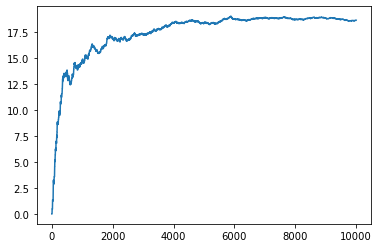

In [34]:
plt.plot(history[:, 0, 0])

## Deep Q-Network

In [117]:
env = gym.make("CartPole-v1")
input_shape = [4]
n_outputs = 2

model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs),
])

In [118]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [119]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [120]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [121]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [122]:
batch_size = 32
discount_rate = .95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + 
                      (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1,1)
    mask = tf.one_hot(actions, n_outputs,)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, 
                                 axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [123]:
rewards = []
best_score = 0

In [124]:
for episode in range(1200):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 51, Steps: 90, eps: 0.898WARNING:tensorflow:Layer dense_31 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Episode: 1199, Steps: 83, eps: 0.0100

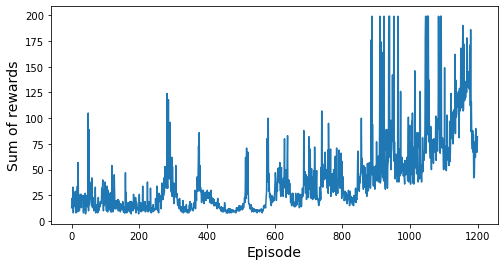

In [125]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [136]:
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    

In [137]:
plot_animation(frames)
env.close()

In [138]:
!pip install tf-agents

     |████████████████████████████████| 903 kB 549 kB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 1.5 MB/s  eta 0:00:01
ERROR: tensorflow 2.1.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
You should consider upgrading via the '/home/tornike/.anaconda3/envs/ml_w_py/bin/python -m pip install --upgrade pip' command.


## TF-Agents

In [13]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [15]:
env.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))

In [26]:
env.action_spec()
step = env.step(np.array(1))
print(step)
print(step.is_last())

TimeStep(step_type=array(1, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))
False


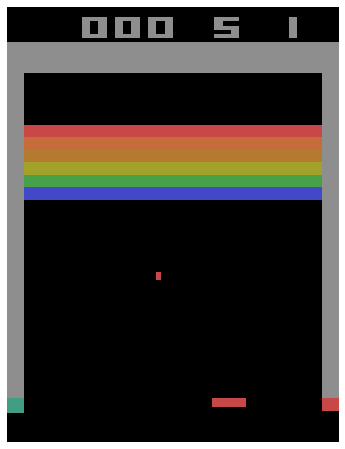

In [24]:
def plot_env(env):
    img = env.render(mode='rgb_array')
    plt.figure(figsize=(6,8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    env.close()

plot_env(env)

In [27]:
env.gym.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']